# Tensorflow version 

In [2]:
# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


# Augmenting the Data 

In [ ]:
import os
import shutil
import random


# Path to the original dataset - I have two copies of the orignal set, used Hagridset1 for changing
dataset_path = 'hagridset1'
classes = [
    'call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
    'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted',
    'three', 'three2', 'two_up', 'two_up_inverted'
]

# Create new directories for train/val/test
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Split ratios
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Function to create a class subfolder
def create_class_subfolders(base_dir):
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

# Create class subfolders
create_class_subfolders(train_dir)
create_class_subfolders(val_dir)
create_class_subfolders(test_dir)

# Function to split data
def split_and_copy(class_name):
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    train_split = int(train_ratio * len(images))
    val_split = int((train_ratio + val_ratio) * len(images))

    for img in images[:train_split]:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in images[train_split:val_split]:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

    for img in images[val_split:]:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Split data for each class
for class_name in classes:
    split_and_copy(class_name)


# Code for models

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam



In [2]:
# Setting random seed
student_id = 396053
random.seed(student_id)
np.random.seed(student_id)
tf.random.set_seed(student_id)

# Dataset paths
# Split into 70% Training, 20% Validation, and 10% Testing 
train_data_dir = 'hagridset1/train'
val_data_dir = 'hagridset1/val'
test_data_dir = 'hagridset1/test'

In [3]:
# Helper functions - Graphs
def plot_history(history):
    """Plot training history"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [4]:
def evaluate_model(model, test_data):
    test_data.reset()
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes
    class_labels = list(test_data.class_indices.keys())

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# CNNs from scratch

In [5]:
def build_cnn_scratch(input_shape=(64, 64, 3), num_classes=10, learning_rate=0.001, deeper=False, reduce_overfitting=False):
    model = Sequential()

    # Initial convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    if deeper:
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(512, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))

    if reduce_overfitting:
        model.add(Dropout(0.5))  
        model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


Training model: cnn_64x64_rgb
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 508s 368ms/step - loss: 2.5427 - accuracy: 0.1935 - val_loss: 2.0592 - val_accuracy: 0.3374
Epoch 2/15
1378/1378 [==============================] - 464s 337ms/step - loss: 2.0070 - accuracy: 0.3578 - val_loss: 1.6669 - val_accuracy: 0.4755
Epoch 3/15
1378/1378 [==============================] - 437s 317ms/step - loss: 1.6871 - accuracy: 0.4596 - val_loss: 1.4116 - val_accuracy: 0.5407
Epoch 4/15
1378/1378 [==============================] - 442s 321ms/step - loss: 1.4730 - accuracy: 0.5258 - val_loss: 1.2118 - val_accuracy: 0.6094
Epoch 5/15
1378/1378 [==============================] - 444s 322ms/step - loss: 1.3138 - accuracy: 0.5824 - val_loss: 1.0936 - val_accuracy: 0.6612
Epoch 6/15
1378/1378 [==============================] - 435s 316ms/step - loss: 1.1896 - accuracy: 

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


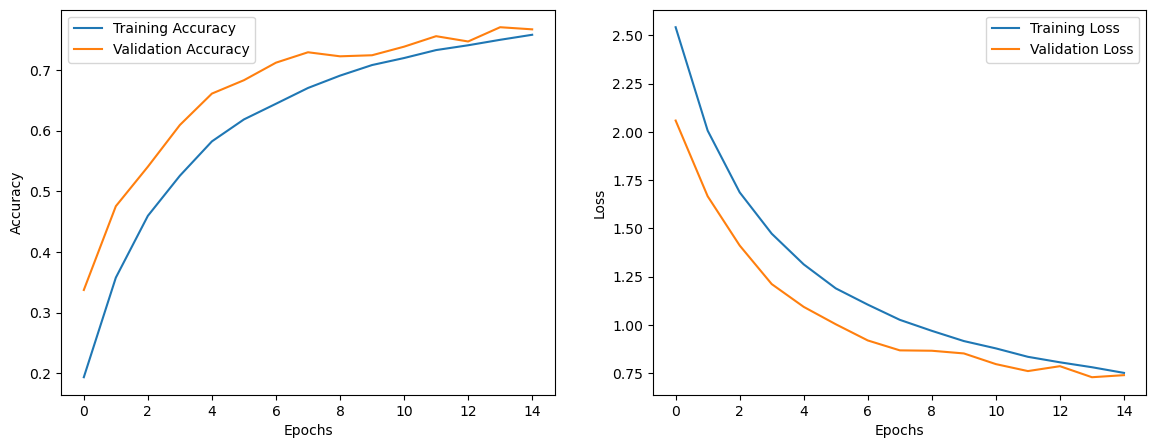

394/394 [==============================] - 65s 164ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.86      0.78      0.82       694
        dislike       0.92      0.87      0.90       703
           fist       0.88      0.79      0.84       689
           four       0.68      0.74      0.71       719
           like       0.77      0.80      0.79       683
           mute       0.88      0.91      0.89       714
             ok       0.75      0.76      0.76       693
            one       0.73      0.68      0.70       707
           palm       0.77      0.79      0.78       706
          peace       0.73      0.60      0.66       697
 peace_inverted       0.86      0.76      0.81       688
           rock       0.71      0.77      0.74       689
           stop       0.81      0.70      0.75       690
  stop_inverted       0.69      0.85      0.76       715
          three       0.59      0.72      0.65       695
      

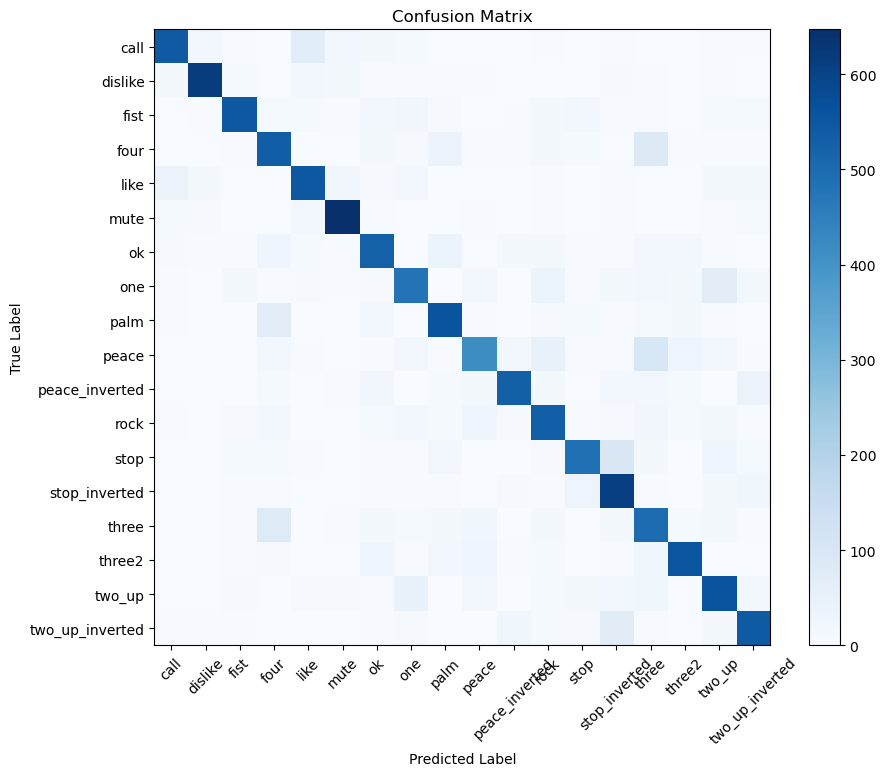

Finished training model: cnn_64x64_rgb
Training model: cnn_128x128_rgb
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 1483s 1s/step - loss: 2.6952 - accuracy: 0.1522 - val_loss: 2.4067 - val_accuracy: 0.2294
Epoch 2/15
1378/1378 [==============================] - 1471s 1s/step - loss: 2.2255 - accuracy: 0.2919 - val_loss: 1.9586 - val_accuracy: 0.3756
Epoch 3/15
1378/1378 [==============================] - 1479s 1s/step - loss: 1.9146 - accuracy: 0.3885 - val_loss: 1.6228 - val_accuracy: 0.4817
Epoch 4/15
1378/1378 [==============================] - 1485s 1s/step - loss: 1.6833 - accuracy: 0.4607 - val_loss: 1.4033 - val_accuracy: 0.5569
Epoch 5/15
1378/1378 [==============================] - 1485s 1s/step - loss: 1.5212 - accuracy: 0.5180 - val_loss: 1.3076 - val_accuracy: 0.5961
Epoch 6/15
1378/1378 [==============================] - 1505s 1s/ste

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


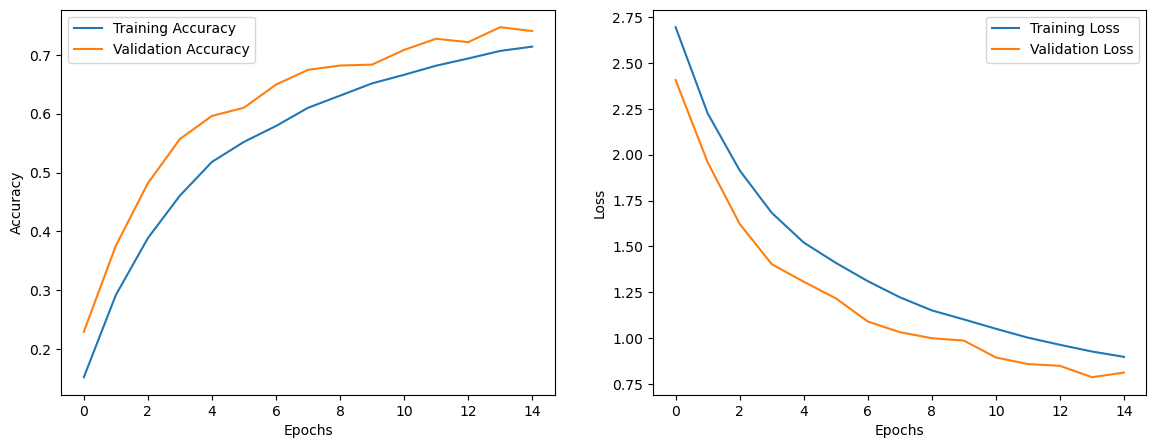

394/394 [==============================] - 96s 243ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.81      0.82      0.82       694
        dislike       0.94      0.78      0.85       703
           fist       0.77      0.78      0.78       689
           four       0.67      0.71      0.69       719
           like       0.80      0.74      0.77       683
           mute       0.82      0.93      0.87       714
             ok       0.79      0.70      0.74       693
            one       0.65      0.66      0.66       707
           palm       0.72      0.77      0.75       706
          peace       0.67      0.57      0.61       697
 peace_inverted       0.79      0.77      0.78       688
           rock       0.63      0.74      0.68       689
           stop       0.69      0.74      0.71       690
  stop_inverted       0.64      0.82      0.72       715
          three       0.67      0.54      0.60       695
      

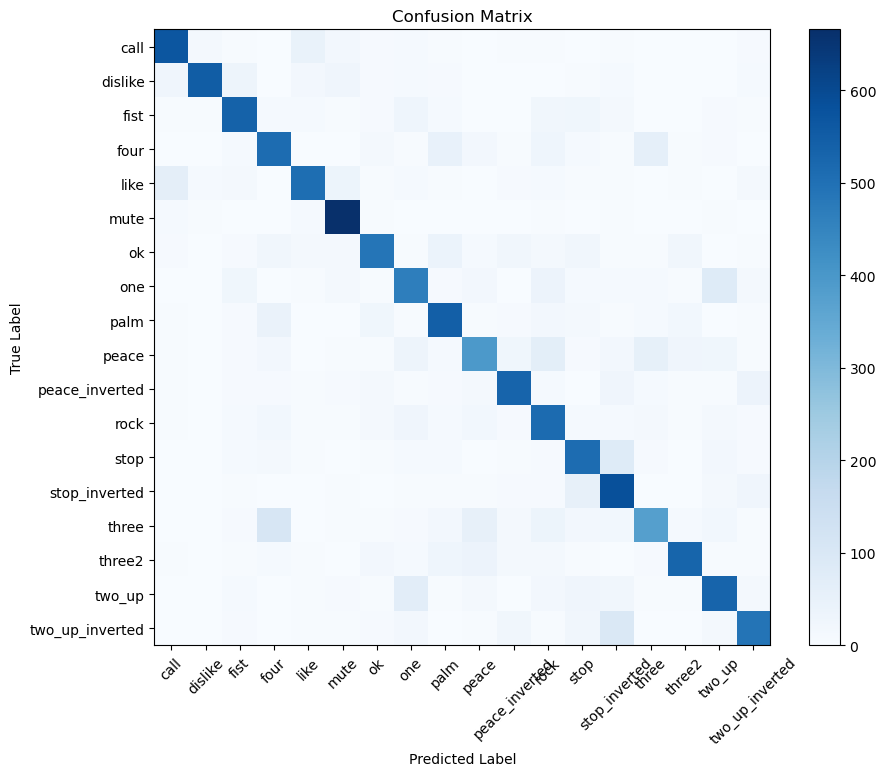

Finished training model: cnn_128x128_rgb
Training model: cnn_64x64_greyscale
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 475s 344ms/step - loss: 2.5959 - accuracy: 0.1744 - val_loss: 2.1873 - val_accuracy: 0.3043
Epoch 2/15
1378/1378 [==============================] - 417s 302ms/step - loss: 2.2004 - accuracy: 0.3003 - val_loss: 1.9656 - val_accuracy: 0.3718
Epoch 3/15
1378/1378 [==============================] - 432s 313ms/step - loss: 1.9813 - accuracy: 0.3709 - val_loss: 1.7411 - val_accuracy: 0.4468
Epoch 4/15
1378/1378 [==============================] - 422s 306ms/step - loss: 1.8202 - accuracy: 0.4185 - val_loss: 1.5855 - val_accuracy: 0.4889
Epoch 5/15
1378/1378 [==============================] - 432s 314ms/step - loss: 1.6927 - accuracy: 0.4610 - val_loss: 1.4838 - val_accuracy: 0.5229
Epoch 6/15
1378/1378 [==============================

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


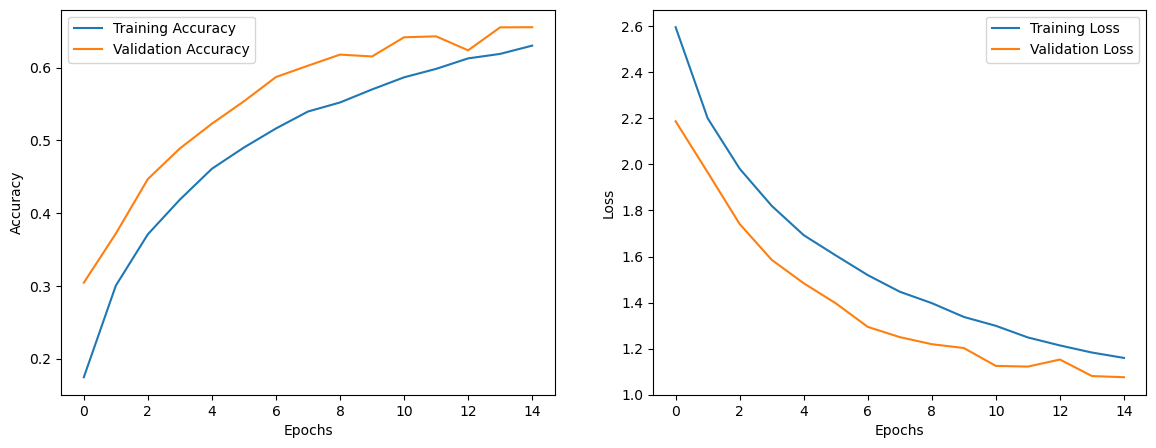

394/394 [==============================] - 47s 118ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.89      0.70      0.79       694
        dislike       0.85      0.85      0.85       703
           fist       0.68      0.71      0.69       689
           four       0.56      0.56      0.56       719
           like       0.67      0.73      0.70       683
           mute       0.82      0.89      0.85       714
             ok       0.57      0.63      0.60       693
            one       0.55      0.49      0.52       707
           palm       0.63      0.68      0.65       706
          peace       0.54      0.43      0.48       697
 peace_inverted       0.71      0.68      0.70       688
           rock       0.62      0.55      0.58       689
           stop       0.63      0.57      0.59       690
  stop_inverted       0.52      0.82      0.64       715
          three       0.59      0.50      0.54       695
      

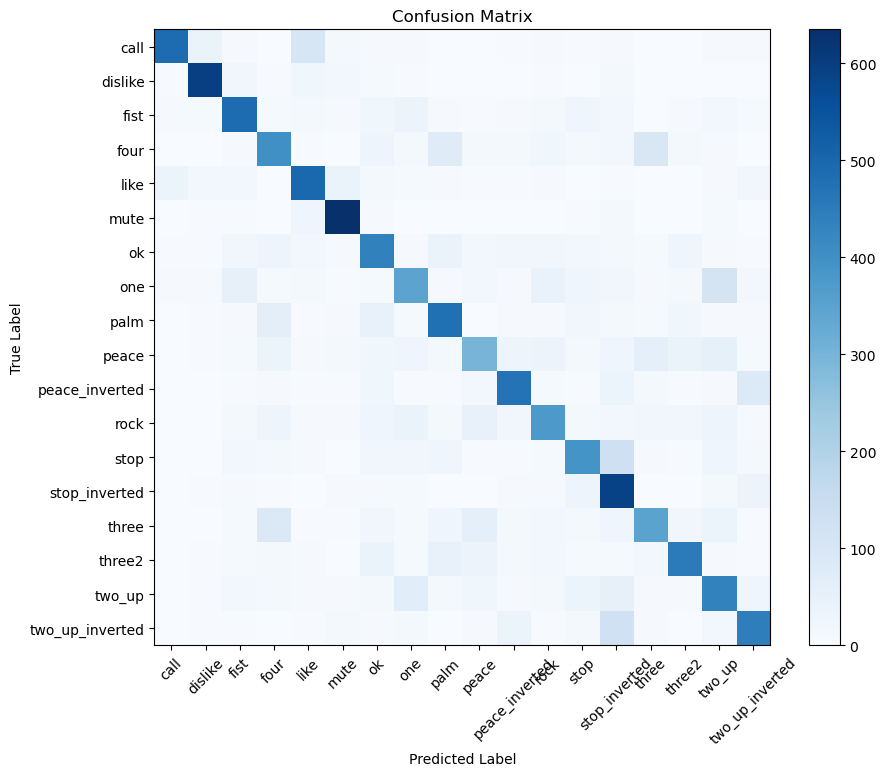

Finished training model: cnn_64x64_greyscale
Training model: cnn_64x64_rgb_deeper
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 406s 294ms/step - loss: 2.5268 - accuracy: 0.1876 - val_loss: 1.7188 - val_accuracy: 0.4333
Epoch 2/15
1378/1378 [==============================] - 420s 305ms/step - loss: 1.4290 - accuracy: 0.5387 - val_loss: 0.9545 - val_accuracy: 0.6944
Epoch 3/15
1378/1378 [==============================] - 414s 300ms/step - loss: 0.9777 - accuracy: 0.6854 - val_loss: 0.6988 - val_accuracy: 0.7748
Epoch 4/15
1378/1378 [==============================] - 410s 298ms/step - loss: 0.7847 - accuracy: 0.7454 - val_loss: 0.6196 - val_accuracy: 0.8059
Epoch 5/15
1378/1378 [==============================] - 407s 295ms/step - loss: 0.6707 - accuracy: 0.7856 - val_loss: 0.5377 - val_accuracy: 0.8275
Epoch 6/15
1378/1378 [=========================

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


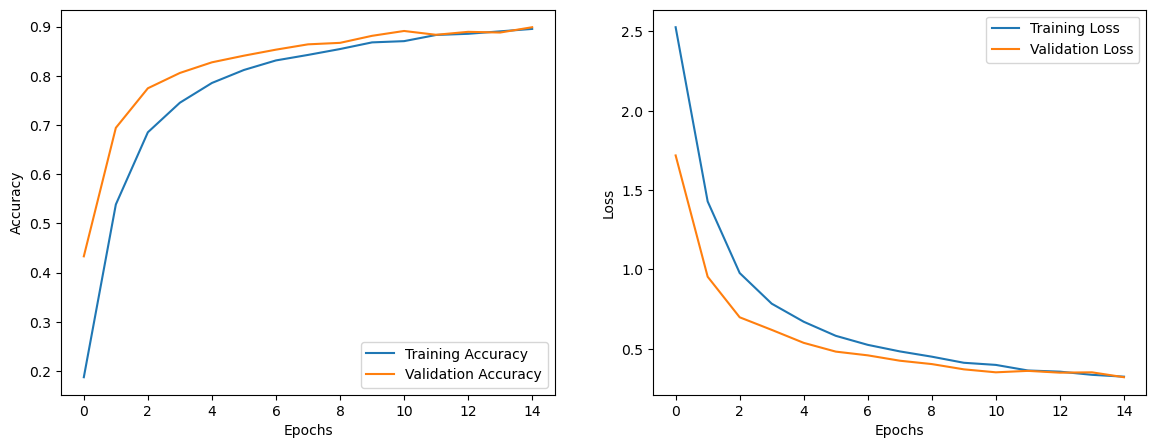

394/394 [==============================] - 46s 115ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.94      0.87      0.91       694
        dislike       0.92      0.95      0.94       703
           fist       0.91      0.92      0.92       689
           four       0.88      0.88      0.88       719
           like       0.87      0.91      0.89       683
           mute       0.96      0.94      0.95       714
             ok       0.91      0.91      0.91       693
            one       0.83      0.86      0.84       707
           palm       0.95      0.89      0.92       706
          peace       0.83      0.88      0.86       697
 peace_inverted       0.94      0.91      0.92       688
           rock       0.95      0.87      0.91       689
           stop       0.86      0.92      0.89       690
  stop_inverted       0.87      0.92      0.90       715
          three       0.88      0.84      0.86       695
      

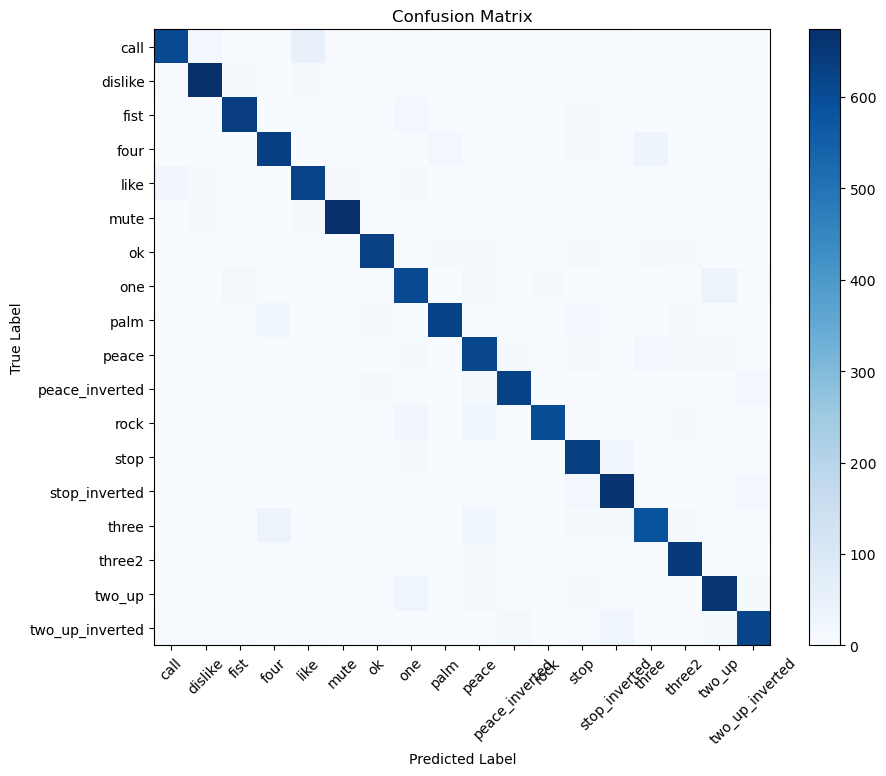

Finished training model: cnn_64x64_rgb_deeper
Training model: cnn_64x64_rgb_overfitting
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 426s 308ms/step - loss: 2.7750 - accuracy: 0.1468 - val_loss: 2.2830 - val_accuracy: 0.2713
Epoch 2/15
1378/1378 [==============================] - 430s 312ms/step - loss: 2.1957 - accuracy: 0.3003 - val_loss: 1.8105 - val_accuracy: 0.4134
Epoch 3/15
1378/1378 [==============================] - 445s 323ms/step - loss: 1.9538 - accuracy: 0.3718 - val_loss: 1.5979 - val_accuracy: 0.4983
Epoch 4/15
1378/1378 [==============================] - 456s 331ms/step - loss: 1.7984 - accuracy: 0.4205 - val_loss: 1.4562 - val_accuracy: 0.5438
Epoch 5/15
1378/1378 [==============================] - 465s 338ms/step - loss: 1.6707 - accuracy: 0.4602 - val_loss: 1.3080 - val_accuracy: 0.5851
Epoch 6/15
1378/1378 [===================

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


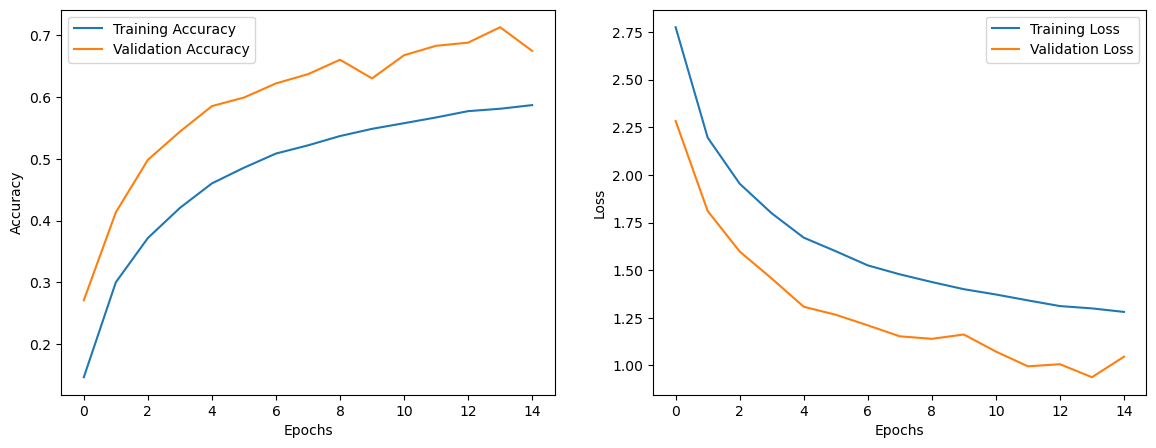

394/394 [==============================] - 50s 127ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.89      0.64      0.74       694
        dislike       0.88      0.77      0.82       703
           fist       0.77      0.77      0.77       689
           four       0.59      0.66      0.62       719
           like       0.78      0.71      0.75       683
           mute       0.80      0.88      0.84       714
             ok       0.84      0.53      0.65       693
            one       0.59      0.57      0.58       707
           palm       0.86      0.59      0.70       706
          peace       0.51      0.59      0.54       697
 peace_inverted       0.79      0.64      0.70       688
           rock       0.56      0.73      0.64       689
           stop       0.76      0.58      0.65       690
  stop_inverted       0.55      0.81      0.66       715
          three       0.54      0.53      0.53       695
      

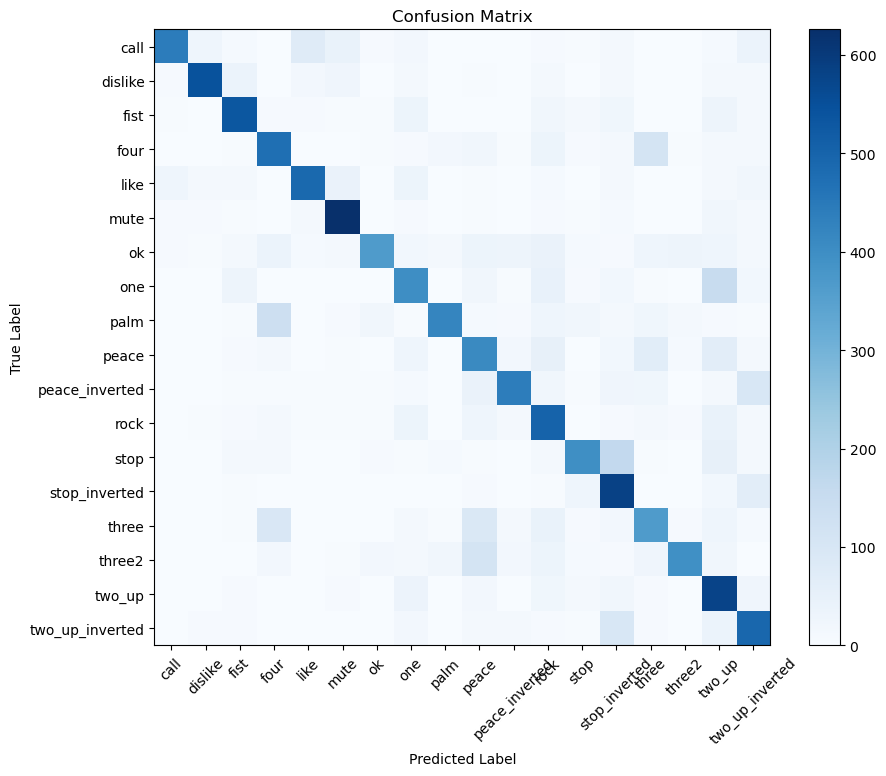

Finished training model: cnn_64x64_rgb_overfitting


In [7]:
# Data augmentation and dataset creation
def create_data_generators(img_size=(128, 128), batch_size=32, color_mode='rgb'):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_data = datagen_train.flow_from_directory(
        train_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )

    val_data = datagen_val_test.flow_from_directory(
        val_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )

    test_data = datagen_val_test.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False
    )

    return train_data, val_data, test_data

# Hyperparameters
learning_rate = 0.0005
batch_size = 32
epochs = 15
num_classes = 18  

# Model Variations
model_variations = [
    {"name": "cnn_64x64_rgb", "img_size": (64, 64), "color_mode": 'rgb', "deeper": False, "reduce_overfitting": False},
    {"name": "cnn_128x128_rgb", "img_size": (128, 128), "color_mode": 'rgb', "deeper": False, "reduce_overfitting": False},
    {"name": "cnn_64x64_greyscale", "img_size": (64, 64), "color_mode": 'grayscale', "deeper": False, "reduce_overfitting": False},
    {"name": "cnn_64x64_rgb_deeper", "img_size": (64, 64), "color_mode": 'rgb', "deeper": True, "reduce_overfitting": False},
    {"name": "cnn_64x64_rgb_overfitting", "img_size": (64, 64), "color_mode": 'rgb', "deeper": False, "reduce_overfitting": True},
]

# Train and save each model
for variation in model_variations:
    print(f"Training model: {variation['name']}")

    # Create data generators
    train_data, val_data, test_data = create_data_generators(img_size=variation['img_size'], batch_size=batch_size, color_mode=variation['color_mode'])

    # Build model
    model = build_cnn_scratch(input_shape=variation['img_size'] + ((1,) if variation['color_mode'] == 'grayscale' else (3,)),
                              num_classes=num_classes,
                              learning_rate=learning_rate,
                              deeper=variation['deeper'],
                              reduce_overfitting=variation['reduce_overfitting'])

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size
    )

    # Save model
    model.save(f"{variation['name']}.h5")

    # Plot training history
    plot_history(history)

    # Evaluate model
    evaluate_model(model, test_data)

    print(f"Finished training model: {variation['name']}")

Training model: vgg16_64x64_rgb
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 943s 682ms/step - loss: 1.7373 - accuracy: 0.4329 - val_loss: 1.3402 - val_accuracy: 0.5449
Epoch 2/15
1378/1378 [==============================] - 897s 651ms/step - loss: 1.2787 - accuracy: 0.5796 - val_loss: 1.1344 - val_accuracy: 0.6261
Epoch 3/15
1378/1378 [==============================] - 894s 649ms/step - loss: 1.1200 - accuracy: 0.6314 - val_loss: 1.0783 - val_accuracy: 0.6423
Epoch 4/15
1378/1378 [==============================] - 888s 644ms/step - loss: 1.0114 - accuracy: 0.6636 - val_loss: 1.0424 - val_accuracy: 0.6603
Epoch 5/15
1378/1378 [==============================] - 892s 647ms/step - loss: 0.9443 - accuracy: 0.6877 - val_loss: 0.9821 - val_accuracy: 0.6807
Epoch 6/15
1378/1378 [==============================] - 885s 642ms/step - loss: 0.8881 - accuracy

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


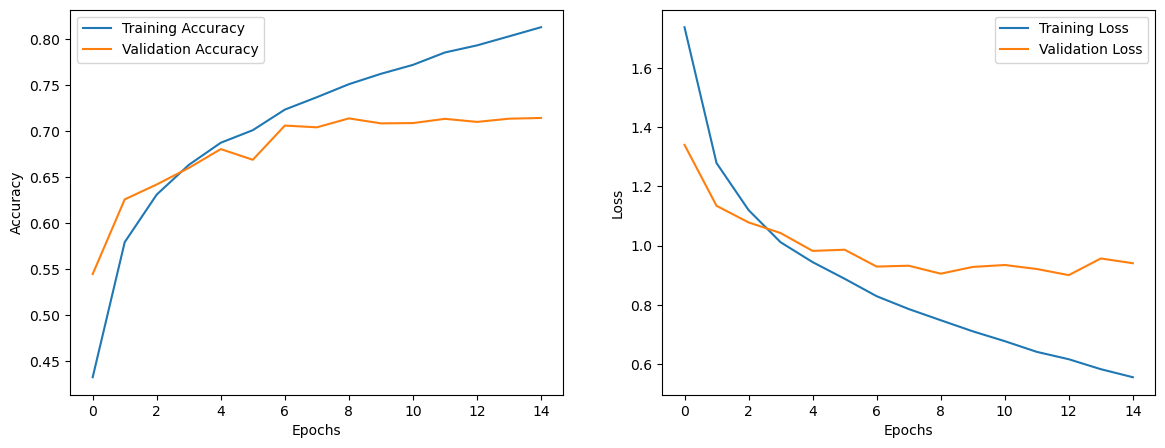

394/394 [==============================] - 127s 322ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.82      0.89      0.85       694
        dislike       0.90      0.90      0.90       703
           fist       0.79      0.78      0.78       689
           four       0.69      0.62      0.65       719
           like       0.81      0.83      0.82       683
           mute       0.87      0.92      0.89       714
             ok       0.67      0.72      0.69       693
            one       0.54      0.62      0.58       707
           palm       0.80      0.68      0.74       706
          peace       0.63      0.49      0.55       697
 peace_inverted       0.78      0.71      0.74       688
           rock       0.66      0.62      0.64       689
           stop       0.67      0.69      0.68       690
  stop_inverted       0.74      0.79      0.77       715
          three       0.57      0.59      0.58       695
     

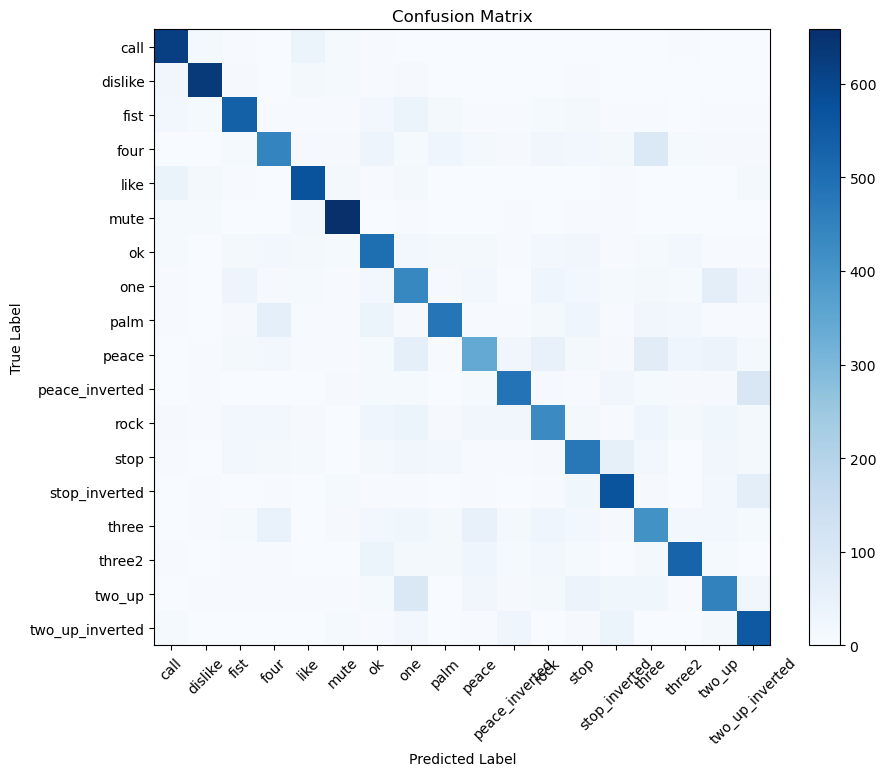

Finished training model: vgg16_64x64_rgb
Training model: vgg16_128x128_rgb
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 2452s 2s/step - loss: 1.0359 - accuracy: 0.6621 - val_loss: 0.5750 - val_accuracy: 0.8072
Epoch 2/15
1378/1378 [==============================] - 2466s 2s/step - loss: 0.5389 - accuracy: 0.8237 - val_loss: 0.4682 - val_accuracy: 0.8420
Epoch 3/15
1378/1378 [==============================] - 2346s 2s/step - loss: 0.4160 - accuracy: 0.8614 - val_loss: 0.4071 - val_accuracy: 0.8677
Epoch 4/15
1378/1378 [==============================] - 2337s 2s/step - loss: 0.3485 - accuracy: 0.8841 - val_loss: 0.3874 - val_accuracy: 0.8780
Epoch 5/15
1378/1378 [==============================] - 2340s 2s/step - loss: 0.2955 - accuracy: 0.9017 - val_loss: 0.3726 - val_accuracy: 0.8834
Epoch 6/15
1378/1378 [==============================] - 2351s 2s

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


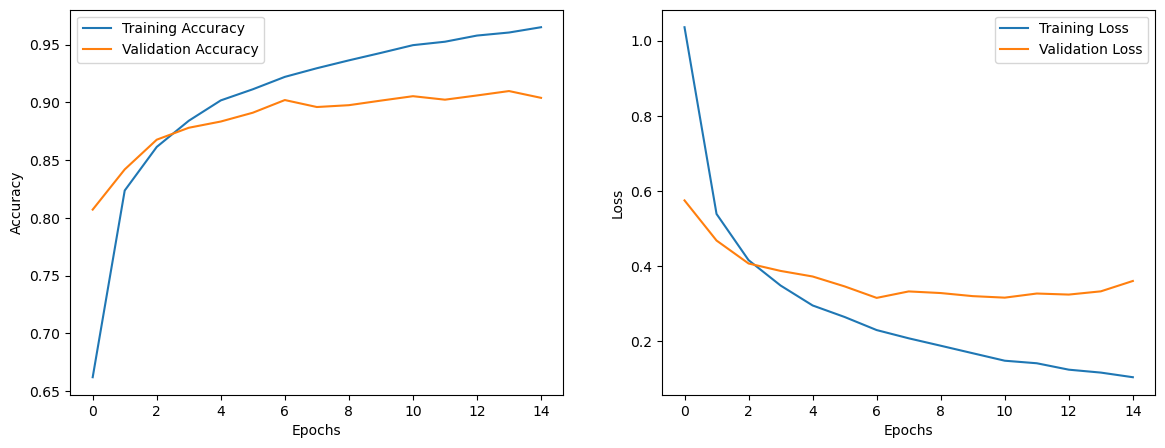

394/394 [==============================] - 430s 1s/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.94      0.95      0.94       694
        dislike       0.99      0.95      0.97       703
           fist       0.95      0.90      0.93       689
           four       0.89      0.86      0.88       719
           like       0.89      0.94      0.92       683
           mute       0.99      0.96      0.98       714
             ok       0.92      0.93      0.92       693
            one       0.78      0.84      0.81       707
           palm       0.91      0.93      0.92       706
          peace       0.81      0.81      0.81       697
 peace_inverted       0.98      0.88      0.93       688
           rock       0.86      0.87      0.87       689
           stop       0.90      0.89      0.89       690
  stop_inverted       0.93      0.88      0.91       715
          three       0.84      0.84      0.84       695
        

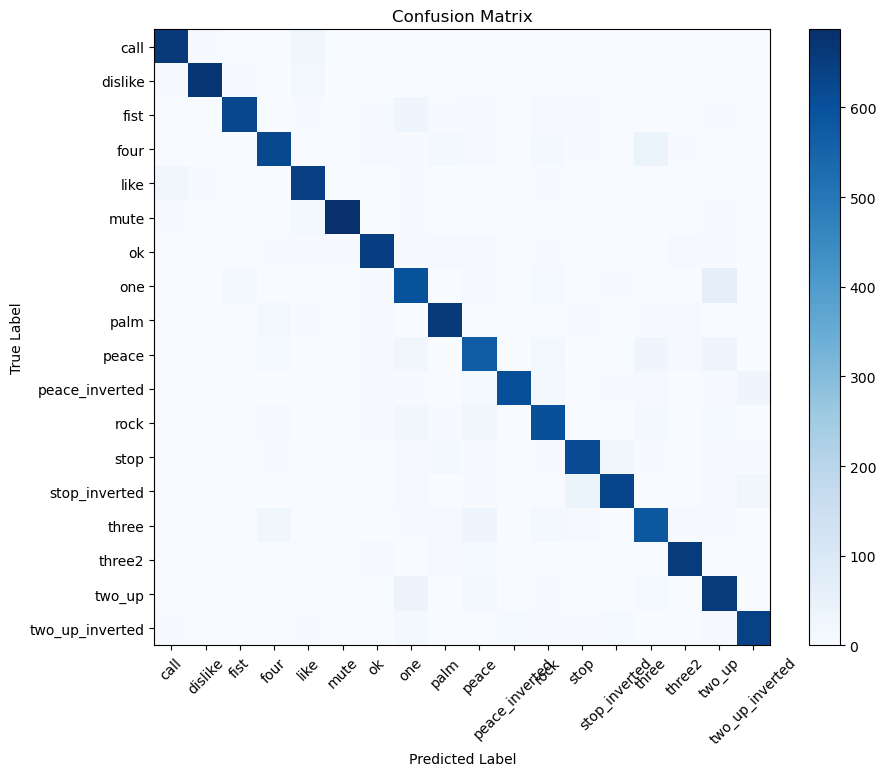

Finished training model: vgg16_128x128_rgb
Training model: vgg16_64x64_rgb_deeper
Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Epoch 1/15
1378/1378 [==============================] - 822s 596ms/step - loss: 1.7578 - accuracy: 0.4222 - val_loss: 1.3346 - val_accuracy: 0.5627
Epoch 2/15
1378/1378 [==============================] - 820s 595ms/step - loss: 1.2973 - accuracy: 0.5722 - val_loss: 1.1639 - val_accuracy: 0.6093
Epoch 3/15
1378/1378 [==============================] - 825s 599ms/step - loss: 1.1378 - accuracy: 0.6231 - val_loss: 1.0447 - val_accuracy: 0.6544
Epoch 4/15
1378/1378 [==============================] - 834s 605ms/step - loss: 1.0337 - accuracy: 0.6549 - val_loss: 0.9871 - val_accuracy: 0.6733
Epoch 5/15
1378/1378 [==============================] - 826s 600ms/step - loss: 0.9563 - accuracy: 0.6836 - val_loss: 0.9917 - val_accuracy: 0.6749
Epoch 6/15
1378/1378 [=========================

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


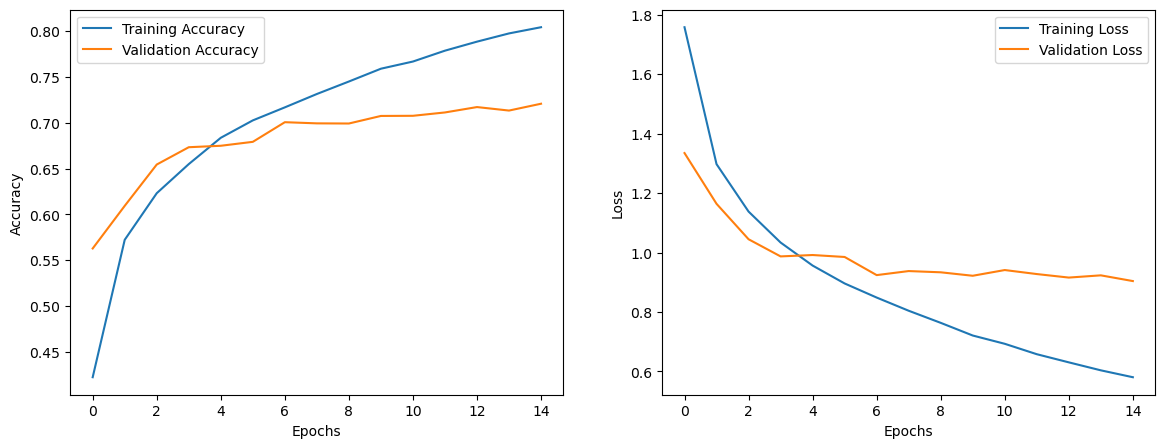

394/394 [==============================] - 122s 308ms/step
Classification Report:
                 precision    recall  f1-score   support

           call       0.87      0.86      0.87       694
        dislike       0.93      0.90      0.91       703
           fist       0.78      0.79      0.78       689
           four       0.69      0.65      0.67       719
           like       0.88      0.78      0.83       683
           mute       0.90      0.95      0.93       714
             ok       0.62      0.74      0.68       693
            one       0.60      0.59      0.59       707
           palm       0.77      0.71      0.74       706
          peace       0.53      0.59      0.56       697
 peace_inverted       0.70      0.82      0.75       688
           rock       0.64      0.61      0.62       689
           stop       0.81      0.58      0.67       690
  stop_inverted       0.66      0.80      0.73       715
          three       0.62      0.54      0.58       695
     

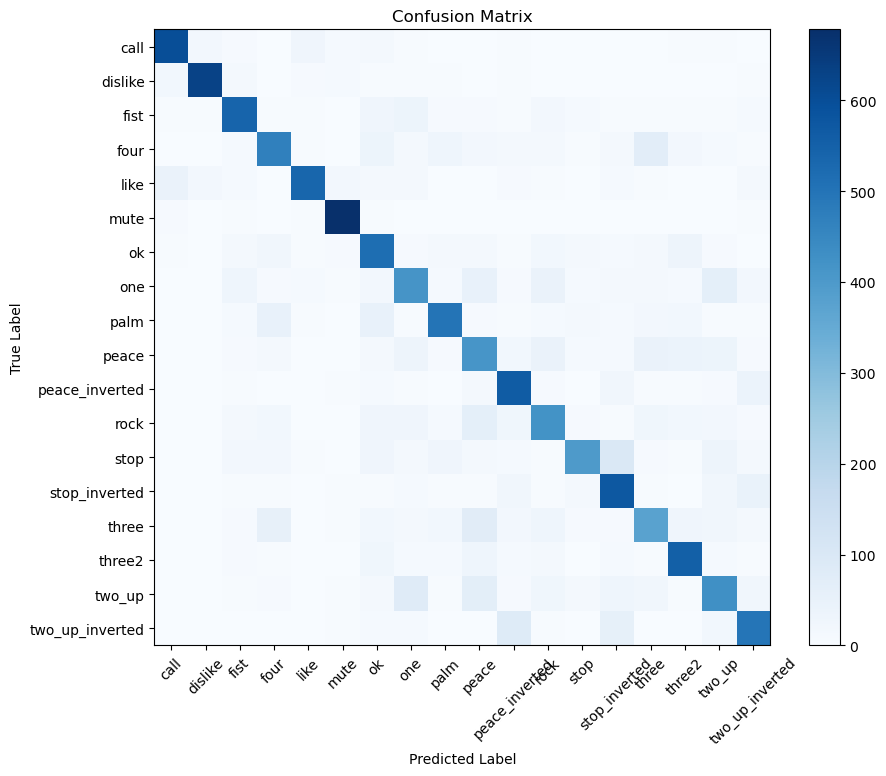

Finished training model: vgg16_64x64_rgb_deeper


In [7]:
def create_data_generators(img_size=(128, 128), batch_size=32, color_mode='rgb'):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_data = datagen_train.flow_from_directory(
        train_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )

    val_data = datagen_val_test.flow_from_directory(
        val_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )

    test_data = datagen_val_test.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False
    )

    return train_data, val_data, test_data

# Function to build a VGG16-based transfer learning model
def build_vgg16_transfer(input_shape=(128, 128, 3), num_classes=18, learning_rate=0.0001, reduce_overfitting=False, deeper=False):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tuning deeper layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)

    if deeper:
        x = Dense(1024, activation='relu')(x)
        
    if reduce_overfitting:
        x = Dropout(0.5)(x)
        x = BatchNormalization()(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameters
learning_rate = 0.0001
batch_size = 32
epochs = 15
num_classes = 18 

# Model Variations
model_variations_vgg16 = [
    {"name": "vgg16_64x64_rgb", "img_size": (64, 64), "color_mode": 'rgb', "reduce_overfitting": False},
    {"name": "vgg16_128x128_rgb", "img_size": (128, 128), "color_mode": 'rgb', "reduce_overfitting": False},
    {"name": "vgg16_64x64_rgb_deeper", "img_size": (64, 64), "color_mode": 'rgb', "reduce_overfitting": False, "deeper": True}
]


# Training and evaluation loop
for variation in model_variations_vgg16:
    print(f"Training model: {variation['name']}")

    # Create data generators
    train_data, val_data, test_data = create_data_generators(img_size=variation['img_size'], batch_size=batch_size, color_mode=variation['color_mode'])

    # Build model with specific configurations
    model = build_vgg16_transfer(
        input_shape=variation['img_size'] + ((1,) if variation['color_mode'] == 'grayscale' else (3,)),
        num_classes=num_classes,
        learning_rate=learning_rate,
        reduce_overfitting=variation['reduce_overfitting'],
        deeper=variation.get('deeper', False)
    )

    # Train model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        batch_size=batch_size
    )

    # Save model
    model.save(f"{variation['name']}.h5")

    # Plot training history
    plot_history(history)

    # Evaluate model
    evaluate_model(model, test_data)

    print(f"Finished training model: {variation['name']}")


# Models without data Augmentation

Found 44072 images belonging to 18 classes.
Found 6296 images belonging to 18 classes.
Found 12602 images belonging to 18 classes.
Training basic CNN model...
Epoch 1/15
1378/1378 [==============================] - 244s 176ms/step - loss: 2.4792 - accuracy: 0.2178 - val_loss: 2.1356 - val_accuracy: 0.3221
Epoch 2/15
1378/1378 [==============================] - 221s 160ms/step - loss: 1.9214 - accuracy: 0.3924 - val_loss: 1.8730 - val_accuracy: 0.4030
Epoch 3/15
1378/1378 [==============================] - 230s 167ms/step - loss: 1.6183 - accuracy: 0.4875 - val_loss: 1.7864 - val_accuracy: 0.4392
Epoch 4/15
1378/1378 [==============================] - 200s 145ms/step - loss: 1.3404 - accuracy: 0.5719 - val_loss: 1.7023 - val_accuracy: 0.4620
Epoch 5/15
1378/1378 [==============================] - 195s 142ms/step - loss: 1.0734 - accuracy: 0.6611 - val_loss: 1.8249 - val_accuracy: 0.4587
Epoch 6/15
1378/1378 [==============================] - 194s 141ms/step - loss: 0.8234 - accuracy: 0.

C:\Users\eoini\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


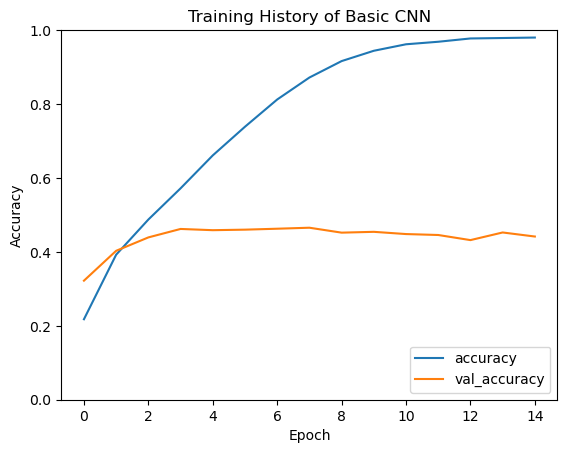

394/394 [==============================] - 45s 115ms/step - loss: 4.3002 - accuracy: 0.4475
Test accuracy: 0.4475
Finished training model: basic_cnn_64x64_rgb
Training VGG-16 model...
Epoch 1/15
1378/1378 [==============================] - 536s 389ms/step - loss: 2.2534 - accuracy: 0.2949 - val_loss: 2.0724 - val_accuracy: 0.3513
Epoch 2/15
1378/1378 [==============================] - 534s 388ms/step - loss: 1.9324 - accuracy: 0.3896 - val_loss: 1.9498 - val_accuracy: 0.3858
Epoch 3/15
1378/1378 [==============================] - 536s 389ms/step - loss: 1.8204 - accuracy: 0.4243 - val_loss: 1.9154 - val_accuracy: 0.3891
Epoch 4/15
1378/1378 [==============================] - 528s 383ms/step - loss: 1.7416 - accuracy: 0.4506 - val_loss: 1.8938 - val_accuracy: 0.4003
Epoch 5/15
1378/1378 [==============================] - 529s 384ms/step - loss: 1.6829 - accuracy: 0.4656 - val_loss: 1.8609 - val_accuracy: 0.4141
Epoch 6/15
1378/1378 [==============================] - 530s 385ms/step - lo

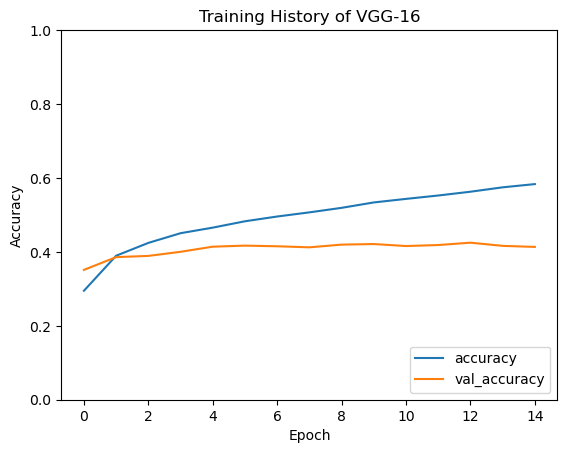

394/394 [==============================] - 132s 334ms/step - loss: 1.9647 - accuracy: 0.4056
Test accuracy: 0.4056
Finished training model: vgg16_64x64_rgb


In [5]:
# Function to create data generators without augmentation
def create_basic_data_generators(img_size=(64, 64), batch_size=32, color_mode='rgb'):
    datagen = ImageDataGenerator(rescale=1./255)

    train_data = datagen.flow_from_directory(
        train_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )

    val_data = datagen.flow_from_directory(
        val_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )

    test_data = datagen.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=False
    )

    return train_data, val_data, test_data

# Function to build a basic CNN model
def build_basic_cnn(input_shape, num_classes, learning_rate=0.0005):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to build a VGG-16 based model
def build_vgg16(input_shape, num_classes, learning_rate=0.0005):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the layers except the last dense layer
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to plot training history
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'Training History of {model_name}')
    plt.show()

# Function to evaluate the model
def evaluate_model(model, test_data):
    test_loss, test_acc = model.evaluate(test_data)
    print(f"Test accuracy: {test_acc:.4f}")

# Hyperparameters
learning_rate = 0.0005
batch_size = 32
epochs = 15
num_classes = 18  

# Model details
img_size = (64, 64)
color_mode = 'rgb'
input_shape = img_size + (3,)  

train_data, val_data, test_data = create_basic_data_generators(img_size=img_size, batch_size=batch_size, color_mode=color_mode)

# Build and train basic CNN model
print("Training basic CNN model...")
cnn_model = build_basic_cnn(input_shape=input_shape, num_classes=num_classes, learning_rate=learning_rate)
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size
)

# Save basic CNN model
cnn_model.save("basic_cnn_64x64_rgb.h5")

# Plot training history for basic CNN model
plot_history(cnn_history, "Basic CNN")

# Evaluate basic CNN model
evaluate_model(cnn_model, test_data)
print("Finished training model: basic_cnn_64x64_rgb")

# Build and train VGG-16 model
print("Training VGG-16 model...")
vgg16_model = build_vgg16(input_shape=input_shape, num_classes=num_classes, learning_rate=learning_rate)
vgg16_history = vgg16_model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size
)

# Save VGG-16 model
vgg16_model.save("basic_vgg16_64x64_rgb.h5")

# Plot training history for VGG-16 model
plot_history(vgg16_history, "VGG-16")

# Evaluate VGG-16 model
evaluate_model(vgg16_model, test_data)
print("Finished training model: vgg16_64x64_rgb")

# Images Testing

Loading model: cnn_64x64_rgb.h5
1/1 [==============================] - 0s 24ms/step


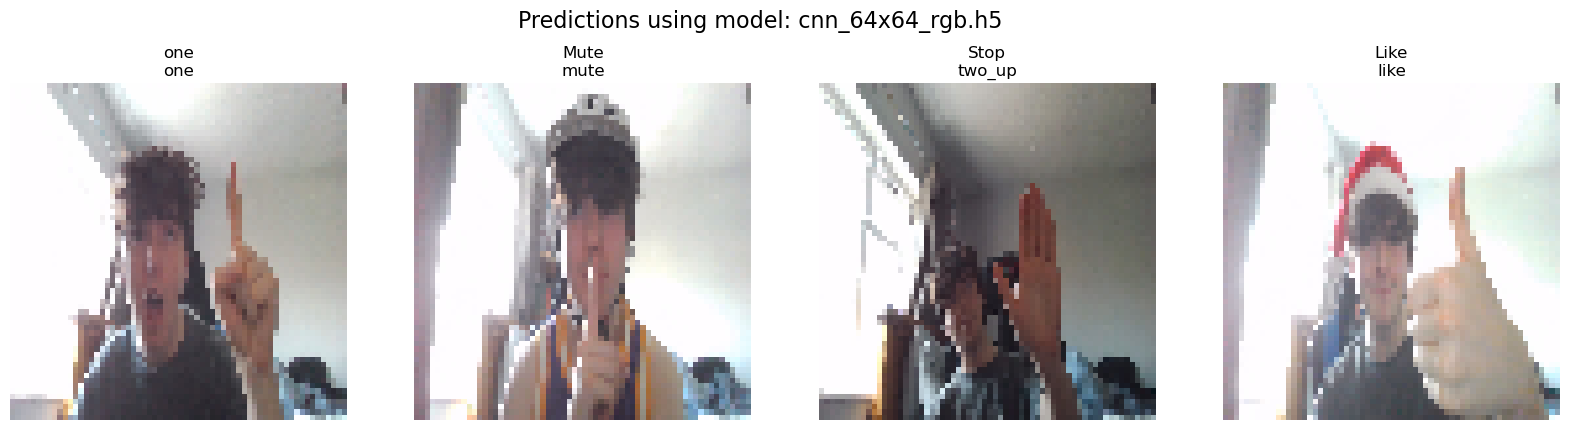

Loading model: cnn_128x128_rgb.h5
1/1 [==============================] - 0s 49ms/step


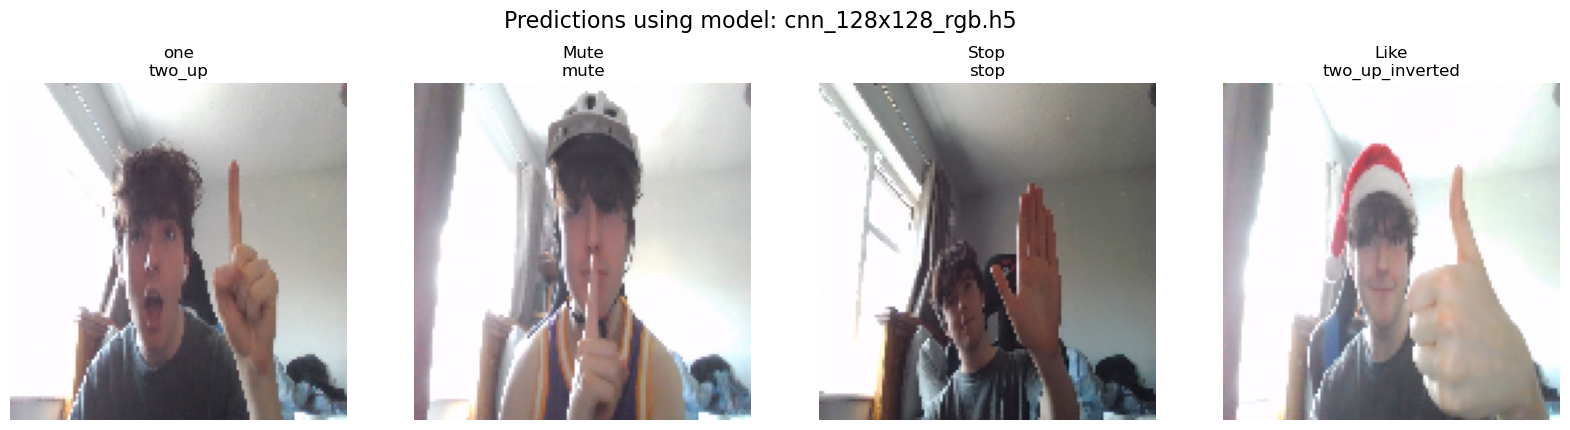

Loading model: cnn_64x64_greyscale.h5
1/1 [==============================] - 0s 25ms/step


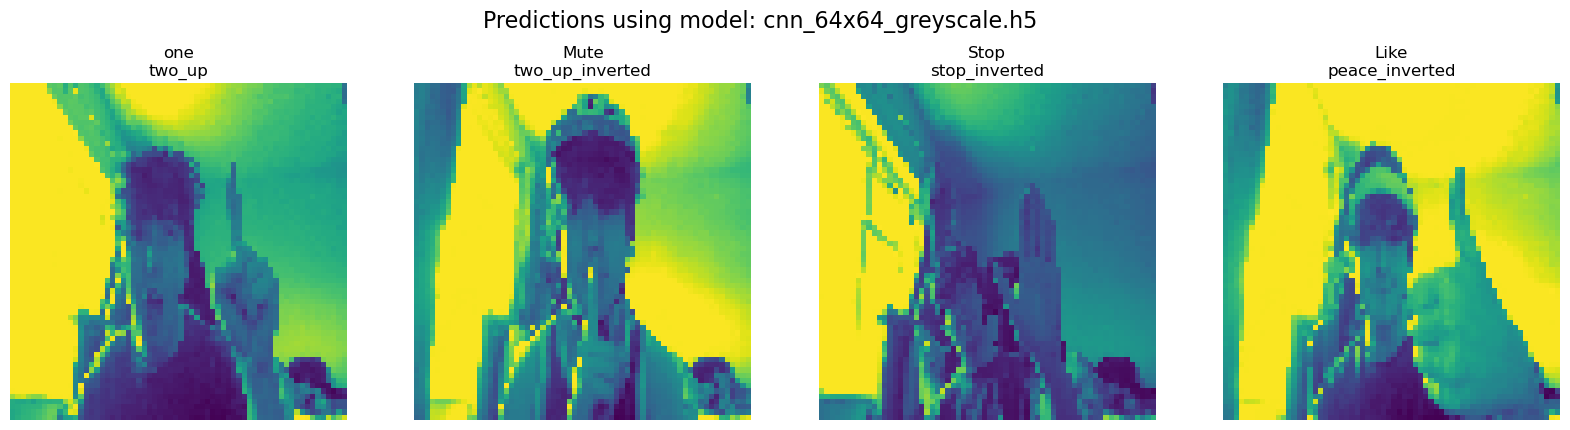

Loading model: cnn_64x64_rgb_deeper.h5
1/1 [==============================] - 0s 20ms/step


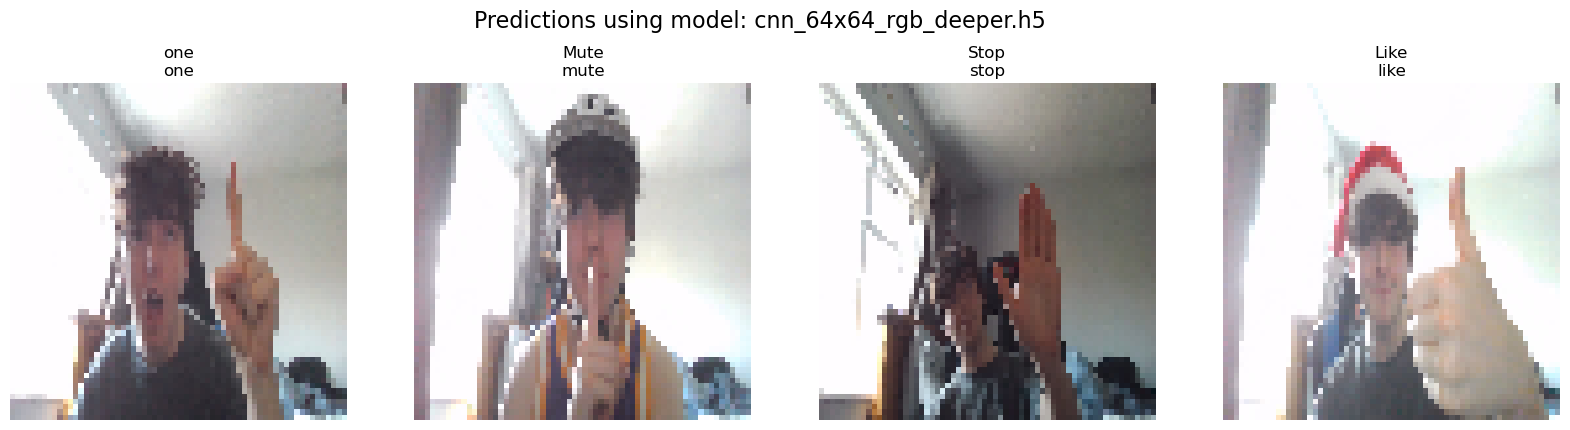

Loading model: cnn_64x64_rgb_overfitting.h5
1/1 [==============================] - 0s 30ms/step


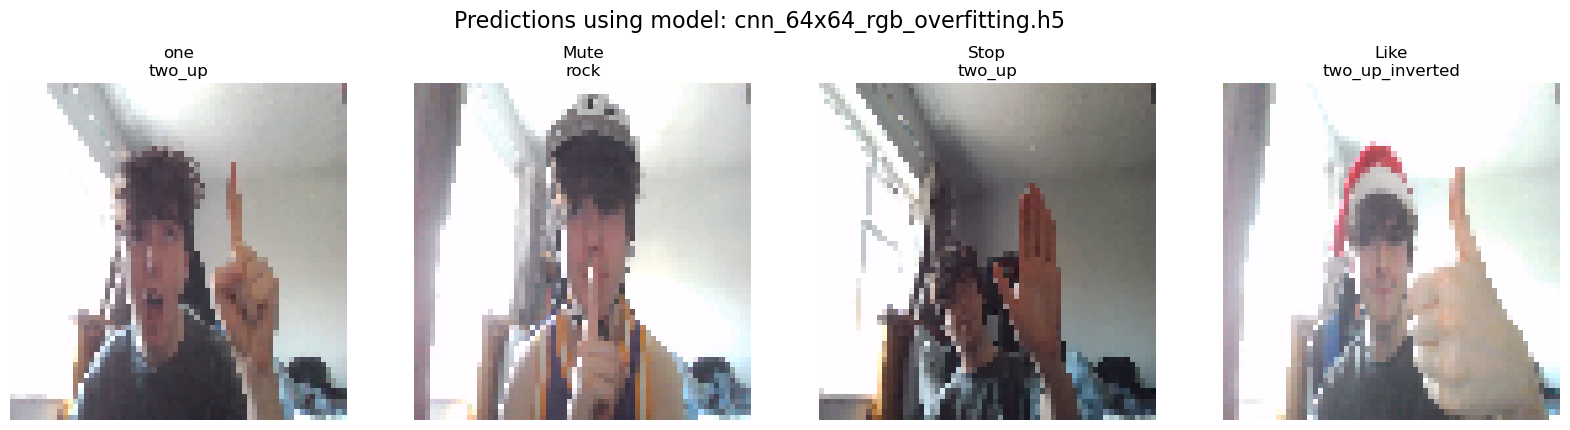

Loading model: vgg16_64x64_rgb.h5
1/1 [==============================] - 0s 39ms/step


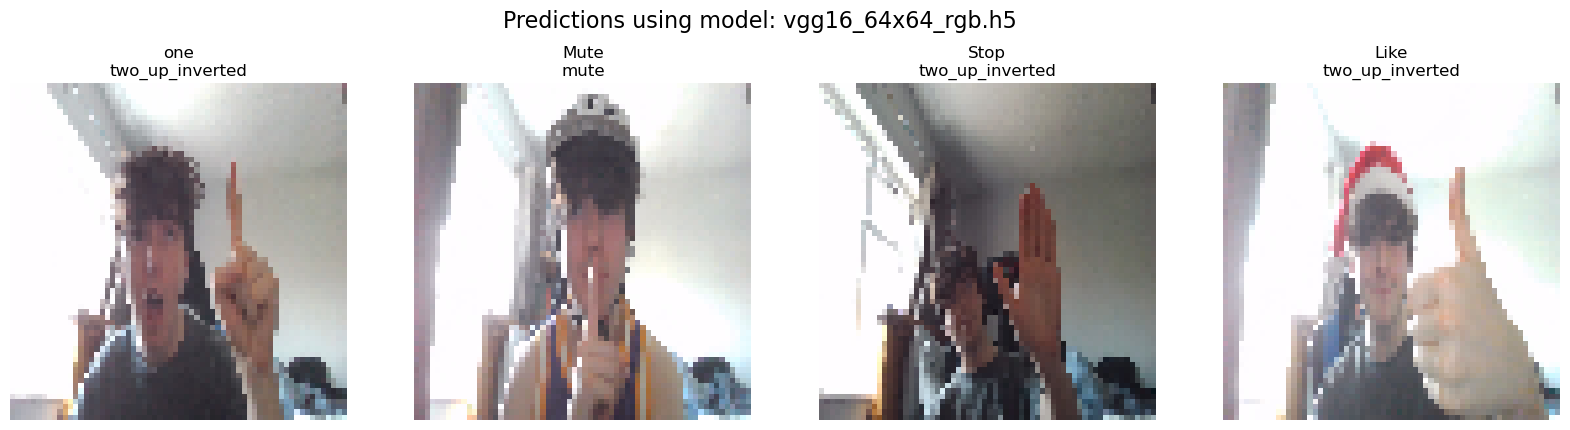

Loading model: vgg16_128x128_rgb.h5
1/1 [==============================] - 0s 62ms/step


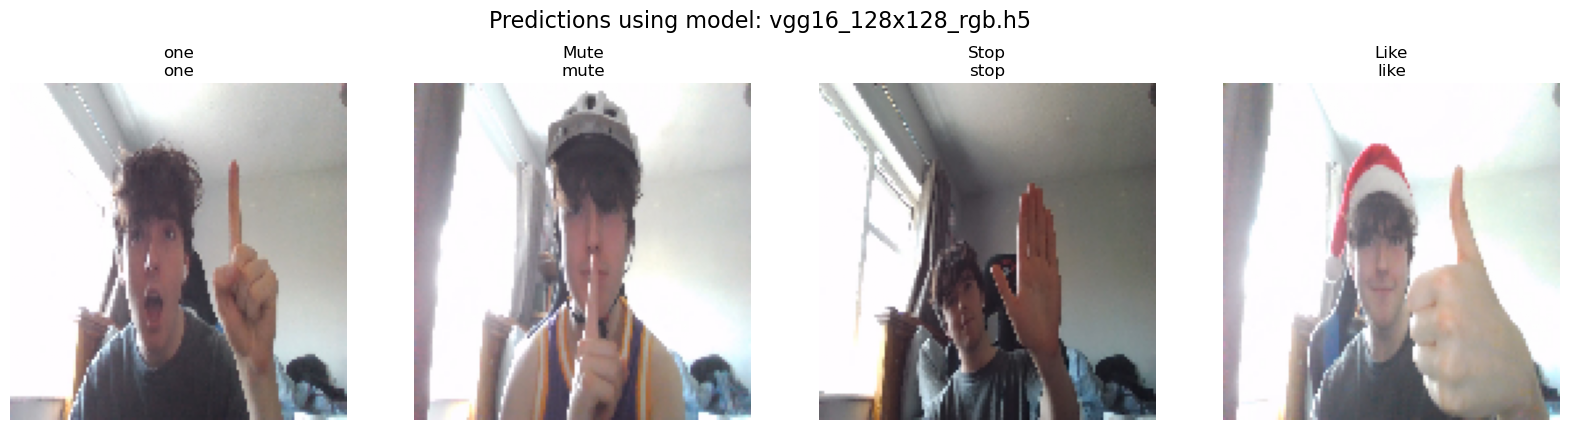

Loading model: vgg16_64x64_rgb_deeper.h5
1/1 [==============================] - 0s 35ms/step


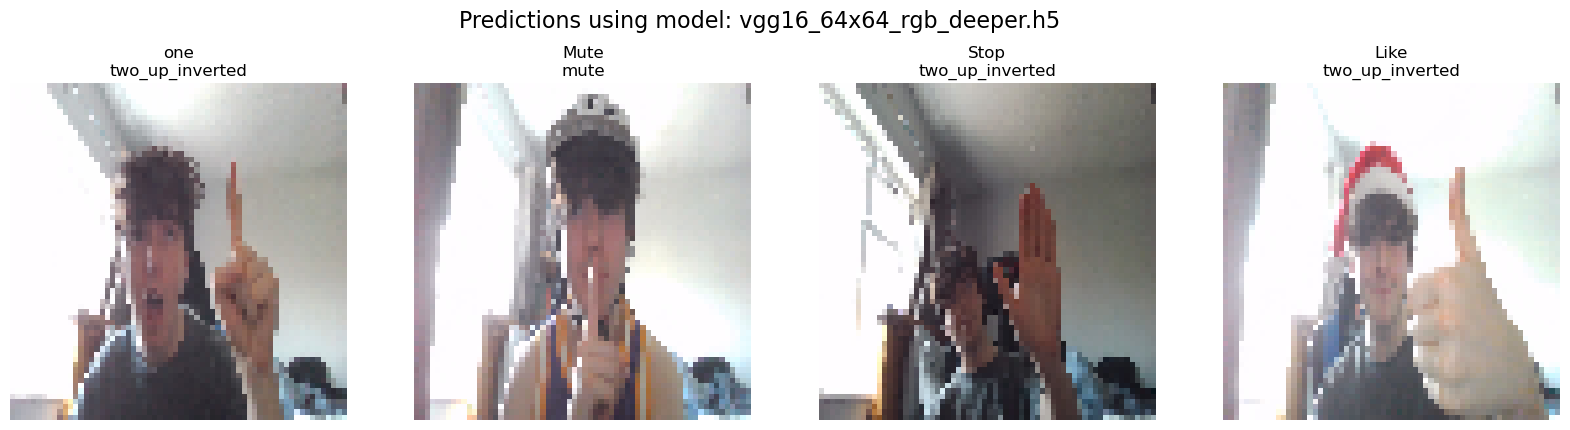

In [9]:
import os
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Define models/Paths
image_folder = "ImagesMe"
image_filenames = ["one.jpg", "Mute.jpg", "Stop.jpg", "Like.jpg"]
model_names = ["cnn_64x64_rgb.h5", "cnn_128x128_rgb.h5", "cnn_64x64_greyscale.h5", "cnn_64x64_rgb_deeper.h5", "cnn_64x64_rgb_overfitting.h5", "vgg16_64x64_rgb.h5", "vgg16_128x128_rgb.h5", "vgg16_64x64_rgb_deeper.h5"]

# Define class names
classes = [
    'call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one',
    'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted',
    'three', 'three2', 'two_up', 'two_up_inverted'
]

# Load each model and make predictions on each image
for model_name in model_names:
    print(f"Loading model: {model_name}")
    model = load_model(model_name)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Predictions using model: {model_name}", fontsize=16)

    for i, image_name in enumerate(image_filenames):
        image_path = os.path.join(image_folder, image_name)
        image = load_img(image_path, target_size=model.input_shape[1:3], color_mode='rgb' if 'rgb' in model_name else 'grayscale')
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image /= 255.0

        # Predict the class
        prediction = model.predict(image)
        predicted_class_index = np.argmax(prediction, axis=1)
        predicted_class_name = classes[predicted_class_index[0]]

        # Show the image and the prediction
        axs[i].imshow(np.squeeze(image), cmap='gray' if 'grayscale' in model_name else None)
        axs[i].set_title(image_name.split('.')[0] + "\n" + predicted_class_name, fontsize=12)
        axs[i].axis('off')

    plt.show()


# Test set result for best model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the model
model = load_model('vgg16_128x128_rgb.h5')

# Define the test data generator
test_datagen = ImageDataGenerator(rescale=0.255)

# Load the test dataset
test_generator = test_datagen.flow_from_directory(
    'hagridset1/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy:.4f}')


Found 12602 images belonging to 18 classes.
394/394 [==============================] - 516s 1s/step - loss: 4.9433 - accuracy: 0.8763
Test accuracy: 0.8763
